In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

### 边界框实现

图片读取

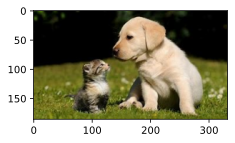

In [2]:
d2l.set_figsize()
img = d2l.plt.imread('./data/picture/cat-dog/cat-dog-1.jpg')
d2l.plt.imshow(img)

`box_corner_to_center` 和 `box_center_to_corner` 实现两角表示法和中心宽度表示法互相转换，`boxes` 可以是 长度为 4 的张量，也可以是 [n, 4] 的二维张量，n 为边界框的数量

In [11]:
def box_corner_to_center(boxes):
    """ 这里的 x1 到 y2，可以是标量也可以是向量，如果输入是 [n, 4] 就是向量 """
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    center_x = (x1 + x2) / 2
    center_y = (y1 + y2) / 2
    width = x2 - x1
    height = y2 - y1
    boxes = torch.stack((center_x, center_y, width, height), axis=-1)
    return boxes

In [14]:
def box_center_to_corner(boxes):
    center_x, center_y, width, height = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = center_x - (width / 2)
    y1 = center_y - (height / 2)
    x2 = width + x1
    y2 = height + y1
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

图片的两角表示边界框

In [25]:
dog_bbox, cat_bbox = [140.0, 10.0, 290.0, 180.0], [60.0, 70.0, 135.0, 180.0]

In [28]:
boxes = torch.tensor((dog_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes, boxes.shape

(tensor([[True, True, True, True],
         [True, True, True, True]]),
 torch.Size([2, 4]))

将两角表示法的边界框转换成 `matplotlib` 的边界框格式

In [20]:
def bbox_to_rect(bbox, color):
    return d2l.plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1], fill=False, edgecolor=color, linewidth=2
    )

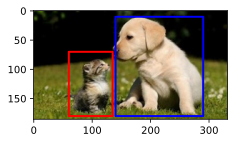

In [27]:
fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'))

### 目标检测数据集

In [29]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l

In [30]:
d2l.DATA_HUB['banana-detection'] = (
    d2l.DATA_URL + 'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72')

读取数据集的图像和标签（所有图片都读到内存里）

In [102]:
def read_data_bananas(is_train=True):
    # data_dir = d2l.download_extract('banana-detection')
    data_dir = os.path.join('.', 'data', 'bananas')
    train_or_val_sub_data_dir = 'bananas_train' if is_train else 'bananas_val'
    csv_fname = os.path.join(data_dir, train_or_val_sub_data_dir, 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name') # 将 img_name 作为 index
    images, targets = [], []
    """ 每个targets """
    for img_name, target in csv_data.iterrows():
        img_data_dir = os.path.join(data_dir, train_or_val_sub_data_dir, 'images', f'{img_name}')
        images.append(torchvision.io.read_image(img_data_dir))
        targets.append(list(target)) # list(target) 将两角表示法的边界框变为 list
    return images, torch.tensor(targets).unsqueeze(1) / 256 # 归一化方便计算机处理提高学习精度

`BananasDataset` 类用于加载数据集的自定义数据集

In [124]:
class BananasDataset(torch.utils.data.Dataset):
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

load 数据集

In [111]:
#@save
def load_data_bananas(batch_size):
    """加载香蕉检测数据集"""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                           batch_size)
    return train_iter, val_iter

In [125]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read1000 training examples
read100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

根据两角法边界框画图，之后需要自己写一个画图函数，d2l 的封装看不懂

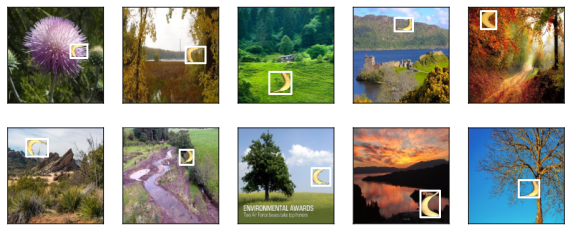

In [126]:
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])